In [1]:
import datasets

train_data, test_data = datasets.load_dataset("rotten_tomatoes", split=["train", "test"])

In [2]:
train_data[0]

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
 'label': 1}

In [3]:
from nltk.tokenize import word_tokenize
import numpy as np

def tokenize_example(example, max_length):
    tokens = word_tokenize(example["text"])[:max_length]
    length = len(tokens)
    return {"tokens": tokens, "length": length}

max_length = 256

train_data = train_data.map(
    tokenize_example, fn_kwargs={"max_length": max_length}
)
test_data = test_data.map(
    tokenize_example, fn_kwargs={"max_length": max_length}
)

In [4]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [5]:
from gensim.corpora import Dictionary

def build_vocab(data, min_count=5):
  """Builds a vocabulary from a list of sentences.

  Args:
    data: A list of sentences.
    min_count: The minimum frequency for a word to be included in the vocabulary.

  Returns:
    A gensim Dictionary object.
  """

  dictionary = Dictionary(data)
  dictionary.filter_extremes(no_below=min_count, no_above=1.0)
  dictionary.add_documents([["<unk>", "<pad>"]])

  return dictionary

min_freq = 5
vocab = build_vocab(train_data["tokens"], min_freq)

In [6]:
unk_index = vocab.token2id.get("<unk>")
pad_index = vocab.token2id.get("<pad>")

vocab.compactify()
vocab.default_index = unk_index

In [7]:
def numericalize_example(example, vocab):
    doc_bow = vocab.doc2bow(example["tokens"])
    ids = [id for id, _ in doc_bow]
    return {"ids": ids}

train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

train_data = train_data.with_format(type="torch", columns=["ids", "label", "length"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label", "length"])
test_data = test_data.with_format(type="torch", columns=["ids", "label", "length"])

Map:   0%|          | 0/6397 [00:00<?, ? examples/s]

Map:   0%|          | 0/2133 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [9]:
import torch
import torch.nn as nn

def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "length": batch_length, "label": batch_label}
        return batch

    return collate_fn

def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [10]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils

class TextClassifierRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers):
        super(TextClassifierRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, x, lengths):
        embedded = self.embedding(x)
        
        # Pack the embedded sequences
        packed_embedded = rnn_utils.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        
        # Pass through the RNN
        packed_output, hidden = self.rnn(packed_embedded)
        
        # Use the hidden state from the last layer
        hidden = hidden[-1,:,:]
        
        # Pass the hidden state through the fully connected layer
        return self.fc(hidden)

In [12]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique("label"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = TextClassifierRNN(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers
)

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 1,235,702 trainable parameters


In [14]:
# Import necessary libraries
import gensim.downloader as api  # For downloading pre-trained word embeddings

word_vectors = api.load('glove-wiki-gigaword-300')  # Download GloVe embeddings with 300 dimensions

# Get the list of words in the vocabulary
words_in_vocab = list(vocab.token2id.keys())  # Get words from the gensim Dictionary

# Create a tensor to store the pre-trained word embeddings
pretrained_embedding = torch.zeros(len(vocab), word_vectors.vector_size)  # Initialize with zeros

# Try to map words in vocabulary to pre-trained word vectors
for i, word in enumerate(words_in_vocab):
    if word in word_vectors:
        pretrained_embedding[i] = torch.tensor(word_vectors[word])

# Set the embedding layer weights in your model
model.embedding.weight.data = pretrained_embedding
lr = 5e-4

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [30]:
import tqdm
def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(dataloader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        length = torch.clamp(length, max=ids.size(1))  
        label = batch["label"].to(device)

        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            length = torch.clamp(length, max=ids.size(1))
            label = batch["label"].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [31]:
import collections
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "lstm.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 5/5 [00:00<00:00, 13.24it/s]


epoch: 0
train_loss: 0.452, train_acc: 0.792
valid_loss: 0.528, valid_acc: 0.744


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]


epoch: 1
train_loss: 0.392, train_acc: 0.827
valid_loss: 0.559, valid_acc: 0.740


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 10.96it/s]


epoch: 2
train_loss: 0.342, train_acc: 0.855
valid_loss: 0.600, valid_acc: 0.733


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 13.01it/s]


epoch: 3
train_loss: 0.304, train_acc: 0.876
valid_loss: 0.694, valid_acc: 0.733


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]


epoch: 4
train_loss: 0.245, train_acc: 0.906
valid_loss: 0.719, valid_acc: 0.740


evaluating...: 100%|██████████| 5/5 [00:00<00:00,  9.20it/s]


epoch: 5
train_loss: 0.208, train_acc: 0.922
valid_loss: 0.788, valid_acc: 0.713


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]


epoch: 6
train_loss: 0.172, train_acc: 0.941
valid_loss: 0.907, valid_acc: 0.727


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]


epoch: 7
train_loss: 0.140, train_acc: 0.952
valid_loss: 1.177, valid_acc: 0.714


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


epoch: 8
train_loss: 0.119, train_acc: 0.957
valid_loss: 1.093, valid_acc: 0.716


evaluating...: 100%|██████████| 5/5 [00:00<00:00, 13.23it/s]

epoch: 9
train_loss: 0.082, train_acc: 0.975
valid_loss: 1.200, valid_acc: 0.720


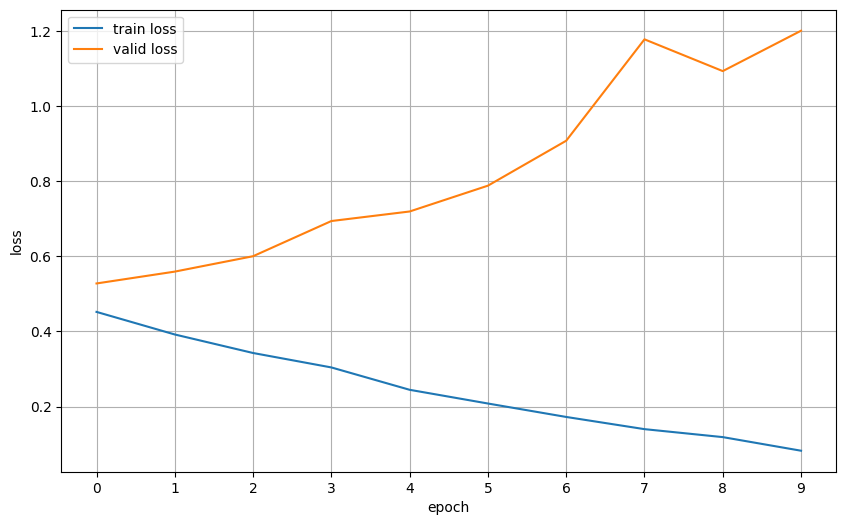

In [32]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()